# Preparing Dataset For LLM as Judge Request


### New Sample Ground Truth

In [ ]:
# cell 1: pip-install if you haven’t already
# !pip install nest_asyncio aiohttp python-dotenv tqdm

import os
import json
import asyncio
import aiohttp
import time
from collections import deque
from tqdm import tqdm
import random
from dotenv import load_dotenv
import nest_asyncio

# ── Patch Jupyter’s event loop ─────────────────────────────────────────────
nest_asyncio.apply()

# ── Load .env ───────────────────────────────────────────────────────────────
env_path = "/work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/.env"
load_dotenv(env_path)
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OPENAI_API_URL = "https://api.openai.com/v1/chat/completions"
MODEL_NAME = "gpt-4o-2024-08-06"

# ── Concurrency / Rate Limiting ─────────────────────────────────────────────
MAX_CONCURRENT_REQUESTS = 4
REQUEST_TIMESTAMPS = deque()

async def enforce_rate_limit():
    while True:
        now = time.time()
        while REQUEST_TIMESTAMPS and now - REQUEST_TIMESTAMPS[0] > 1:
            REQUEST_TIMESTAMPS.popleft()
        if len(REQUEST_TIMESTAMPS) < MAX_CONCURRENT_REQUESTS:
            REQUEST_TIMESTAMPS.append(now)
            return
        await asyncio.sleep(0.1)

# ── GPT-4o Fetch ─────────────────────────────────────────────────────────────
async def fetch_gpt_response(session, sem, item, user_prompt, system_prompt):
    """
    item is a dict with keys:
      - question
      - original_answer
      - template_column
      - fields_str
    """
    async with sem:
        await enforce_rate_limit()
        headers = {
            "Authorization": f"Bearer {OPENAI_API_KEY}",
            "Content-Type": "application/json"
        }
        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt.format(
                question=item["question"],
                text=item["original_answer"]
            )}
        ]
        payload = {
            "model": MODEL_NAME,
            "messages": messages,
        }
        try:
            async with session.post(OPENAI_API_URL, headers=headers, json=payload) as resp:
                if resp.status != 200:
                    err = await resp.text()
                    return {**item, "error": err}
                resp_json = await resp.json()
                content = resp_json["choices"][0]["message"]["content"]
                parsed = json.loads(content)
                return {
                    **item,
                    "processed_response": parsed.get("response")
                }
        except Exception as e:
            return {**item, "error": str(e)}

# ── Extract Q/A + Metadata ─────────────────────────────────────────────────
def extract_items(data, limit=None):
    """
    Walks through the loaded JSON and returns a list of dicts:
      {
        "question": str,
        "original_answer": str,
        "template_column": str|None,
        "fields_str": str
      }
    """
    items = []
    for entry in data:
        db = entry.get("data", {})
        question = db.get("processed_question")
        template_column = db.get("template_column")
        # flatten fields list to "body=id; ..." string
        raw_fields = db.get("fields", [])
        fields_str = "; ".join(f"{f.get('body')}={f.get('id')}" for f in raw_fields if f) or ""
        # find the first "correct" answer annotation
        answer = None
        for ann in entry.get("annotations", []):
            for res in ann.get("result", []):
                if res.get("from_name") == "correct":
                    texts = res.get("value", {}).get("text", [])
                    if texts:
                        answer = texts[0]
                        break
            if answer:
                break
        if not question or not answer:
            continue

        items.append({
            "question": question,
            "original_answer": answer,
            "template_column": template_column,
            "fields_str": fields_str
        })

    if limit:
        return random.sample(items, min(limit, len(items)))
    return items

# ── Process All Items ───────────────────────────────────────────────────────
async def process_all(items, user_prompt, system_prompt):
    sem = asyncio.Semaphore(MAX_CONCURRENT_REQUESTS)
    results = []
    async with aiohttp.ClientSession() as session:
        tasks = [fetch_gpt_response(session, sem, itm, user_prompt, system_prompt)
                 for itm in items]
        for coro in tqdm(asyncio.as_completed(tasks), total=len(tasks), desc="Processing"):
            results.append(await coro)
    return results

# ── Main ────────────────────────────────────────────────────────────────────
async def main():
    # 1) Load input
    input_json_file = "/work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/data/100sample/clean-response-100.json"
    with open(input_json_file, "r", encoding="utf-8") as f:
        data = json.load(f)

    # 2) Extract items
    items = extract_items(data)

    # 3) Prepare prompt
    USER_PROMPT = """
You will be given a **question** and a **text passage** that contains precise information directly answering the question.

**Your task** is to rewrite the text so that it answers the question, while strictly preserving the original meaning and verbosity and completeness.

**Instructions:**
1. **Do not** add, infer, or assume anything not explicitly stated in the text.
2. **Do not** alter the factual meaning or omit any detail.
3. **Do not** include commentary, explanations, or any content beyond the paraphrased answer.
4. **Do not** use your own knowledge — rely solely on the provided text.

**Output Format:**
Respond **only** with a JSON object in the following format:

{{
  "question": "<insert question here>",
  "response": "<insert accurate, paraphrased answer here>"
}}

**Important:** Do **not** add any additional formatting or wrap the response in code block markers.

**Input:**
* Question: "{question}"
* Informative Text: "{text}"
"""
    SYSTEM_PROMPT = ""

    # 4) Run through GPT and collect enhanced items
    results = await process_all(items, USER_PROMPT, SYSTEM_PROMPT)

    # 5) Write out everything, including metadata
    output_file = os.path.join(os.path.dirname(input_json_file), "refined_correct_with_meta.json")
    with open(output_file, "w", encoding="utf-8") as outf:
        json.dump(results, outf, ensure_ascii=False, indent=2)

    print(f"✅ Done. {len(results)} entries saved to {output_file}")

# cell 2: kick it off
await main()


Processing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:57<00:00,  1.52it/s]

✅ Done. 88 entries saved to /work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/data/100sample/refined_correct_with_meta.json


### Retrieving Ground Truth and LLM Response


In [217]:
#!/usr/bin/env python3
"""
Merge refined_correct_with_meta (as ground truth) with multiple LLM response files and
write one CSV per LLM.  Each CSV will contain:

    Question | Template Column | Fields | Ground Truth Answer | <LLM name> Answer
"""

import os
import json
import pandas as pd

# --------------------------------------------------------------------
# Paths – adjust if your directory layout differs
# --------------------------------------------------------------------
deepseek_path = (
    "/work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/"
    "data/100sample/refined_correct_with_meta.json"
)
response_dir = (
    "/work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/"
    "data/llms-response"
)
output_dir = (
    "/work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/"
    "data/ground_truth_vs_llms"
)
os.makedirs(output_dir, exist_ok=True)

# --------------------------------------------------------------------
# 1. Load refined “ground-truth” items
#    Build a map: question  →  {
#        "answer":            processed_response (the paraphrased ground truth),
#        "template_column":   str,
#        "fields":            str
#    }
# --------------------------------------------------------------------
with open(deepseek_path, "r", encoding="utf-8") as f:
    ds_data = json.load(f)

deepseek_map = {}
for entry in ds_data:
    q     = entry.get("question")
    gt    = entry.get("processed_response")
    tcol  = entry.get("template_column", "")
    fields= entry.get("fields_str", "")

    if not q or gt is None:
        continue

    deepseek_map[q] = {
        "answer":          gt,
        "template_column": tcol,
        "fields":          fields,
    }

# --------------------------------------------------------------------
# 2. For each LLM’s response file, merge against our new “ground truth”
# --------------------------------------------------------------------
for fname in os.listdir(response_dir):
    if not fname.endswith(".json"):
        continue

    llm_name = os.path.splitext(fname)[0]
    llm_path = os.path.join(response_dir, fname)

    # Load this LLM's responses
    with open(llm_path, "r", encoding="utf-8") as f:
        llm_data = json.load(f)

    # Build map: question → llm answer (try processed_response first, then answer)
    llm_map = {}
    for entry in llm_data:
        q = entry.get("processed_question") or entry.get("question")
        a = (
            entry.get("processed_response")
            or entry.get("answer")
            or entry.get("original_response")
        )
        if q and a is not None:
            llm_map[q] = a

    # Merge
    records = []
    for question, meta in deepseek_map.items():
        llm_ans = llm_map.get(question)
        if llm_ans is None:
            continue
        records.append({
            "Question":             question,
            "Template Column":      meta["template_column"],
            "Fields":               meta["fields"],
            "Ground Truth Answer":  meta["answer"],
            f"{llm_name} Answer":   llm_ans,
        })

    # Write CSV
    out_csv = os.path.join(output_dir, f"ground_truth_vs_{llm_name}.csv")
    pd.DataFrame(records).to_csv(out_csv, index=False)
    print(f"→ {len(records):>5} records written to {out_csv}")


→    88 records written to /work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/data/ground_truth_vs_llms/ground_truth_vs_grok-3-beta.csv
→    88 records written to /work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/data/ground_truth_vs_llms/ground_truth_vs_mistral_24B.csv
→    88 records written to /work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/data/ground_truth_vs_llms/ground_truth_vs_gpt4o.csv
→    88 records written to /work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/data/ground_truth_vs_llms/ground_truth_vs_claude_3_opus.csv
→    88 records written to /work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/data/ground_truth_vs_llms/ground_truth_vs_phi3.csv
→    88 records written to /work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/data/ground_truth_vs_llms/ground_truth_vs_grok-2.csv
→    88 records written to /work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/data/ground_truth_vs_llms/ground_truth_vs_QwQ-32B.csv
→    

In [140]:
#!/usr/bin/env python3
"""
Merge DeepSeek‑R1 ground‑truth answers with multiple LLM response files and
write one CSV per LLM.  Each CSV now contains:

    Question | Template Column | Fields | Ground Truth Answer | <LLM name> Answer
"""

import os
import json
import pandas as pd

# --------------------------------------------------------------------
# Paths – change if your directory layout differs
# --------------------------------------------------------------------
deepseek_path = (
    "/work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/data/ground_truth.json"
)
response_dir = (
    "/work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/data/llms-response"
)
output_dir = (
    "/work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/data/ground_truth_vs_llms"
)
os.makedirs(output_dir, exist_ok=True)

# --------------------------------------------------------------------
# 1. Load DeepSeek ground‑truth items
#    Build a map: processed_question  →  {
#        "answer":            str,
#        "template_column":   str | None,
#        "fields":            "key1=value1; key2=value2; …"
#    }
# --------------------------------------------------------------------
with open(deepseek_path, "r") as f:
    ds_data = json.load(f)

deepseek_map = {}
for entry in ds_data:
    data_block = entry.get("data", {})
    pq   = data_block.get("processed_question")
    ans  = data_block.get("answer")
    tcol = data_block.get("template_column")

    if not pq or not ans:
        continue

    # Flatten the list of field dictionaries into "Body=ID" pairs
    raw_fields = data_block.get("fields", [])
    fields_str = "; ".join(
        f"{fld.get('body')}={fld.get('id')}" for fld in raw_fields if fld
    ) or ""

    # Keep only items whose annotation includes a "Yes" label
    ok = False
    for ann in entry.get("annotations", []):
        for res in ann.get("result", []):
            if (
                res.get("from_name") == "label"
                and "Yes" in res.get("value", {}).get("choices", [])
            ):
                ok = True
                break
        if ok:
            break
    if not ok:
        continue

    deepseek_map[pq] = {
        "answer": ans,
        "template_column": tcol or "",
        "fields": fields_str,
    }

# --------------------------------------------------------------------
# 2. Process every LLM response file
# --------------------------------------------------------------------
for fname in os.listdir(response_dir):
    if not fname.endswith(".json"):
        continue

    llm_name = os.path.splitext(fname)[0]
    llm_path = os.path.join(response_dir, fname)

    # Load this LLM's responses
    with open(llm_path, "r") as f:
        llm_data = json.load(f)

    # Build map: processed_question or question → answer
    llm_map = {}
    for entry in llm_data:
        q = entry.get("processed_question") or entry.get("question")
        a = entry.get("answer")
        if q and a:
            llm_map[q] = a

    # Merge DeepSeek ground truth with this LLM's answers
    records = []
    for question, meta in deepseek_map.items():
        llm_ans = llm_map.get(question)
        if llm_ans is None:
            continue

        records.append({
            "Question":            question,
            "Template Column":     meta["template_column"],
            "Fields":              meta["fields"],
            "Ground Truth Answer": meta["answer"],
            f"{llm_name} Answer":  llm_ans,
        })

    # Save as CSV
    out_csv = os.path.join(output_dir, f"ground_truth_vs_{llm_name}.csv")
    pd.DataFrame(records).to_csv(out_csv, index=False)
    print(f"→ {len(records):>5} records written to {out_csv}")


→   141 records written to /work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/data/ground_truth_vs_llms/ground_truth_vs_grok-3-beta.csv
→   141 records written to /work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/data/ground_truth_vs_llms/ground_truth_vs_mistral_24B.csv
→   141 records written to /work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/data/ground_truth_vs_llms/ground_truth_vs_gpt4o.csv
→   141 records written to /work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/data/ground_truth_vs_llms/ground_truth_vs_claude_3_opus.csv
→   141 records written to /work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/data/ground_truth_vs_llms/ground_truth_vs_phi3.csv
→   141 records written to /work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/data/ground_truth_vs_llms/ground_truth_vs_grok-2.csv
→   141 records written to /work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/data/ground_truth_vs_llms/ground_truth_vs_QwQ-32B.csv
→   1

### Creating Judge Request Prompt – Version 1


In [45]:
import os
import json
import pandas as pd

# ——— Config ———
# folder containing ground_truth_vs_{llm_name}.csv
csv_dir     = '/work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/data/ground_truth_vs_llms'
# where to dump all JSONL batches
jsonl_dir   = '/work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/data/jsonl_judge_requests'
os.makedirs(jsonl_dir, exist_ok=True)

# your fixed system prompt
judge_system_prompt = """
You are tasked with evaluating the quality of an LLM-generated response. You will be provided with three items:
- A user question
- A ground truth answer
- A system-generated answer from the LLM

Your job is to rate how well the system-generated answer matches the provided ground truth.

Use the following 4-point scale:
1: The system answer is mostly unhelpful: misses key aspects of the ground truth.
2: The system answer is helpful: captures some important points but missed some important point.
3: The system answer is mostly helpful: captures important points but could be improved.
4: The system answer is excellent: highly relevant, detailed, and fully matches the ground truth.

Please structure your output exactly as follows:

Feedback:::
Evaluation: (Provide a detailed explanation of your rationale for the score.)
Total rating: (Give a number between 1 and 4.)

You MUST fill in both 'Evaluation' and 'Total rating' fields.

Now here is the information for evaluation:
"""

batch_size = 200

# ——— Loop through each CSV in csv_dir ———
for fname in os.listdir(csv_dir):
    if not fname.endswith('.csv'):
        continue

    llm_name = os.path.splitext(fname)[0].replace('ground_truth_vs_', '')
    csv_path = os.path.join(csv_dir, fname)
    df = pd.read_csv(csv_path)

    # assume the DataFrame columns are: Question, Ground Truth Answer, <LLM_NAME> Answer
    question_col    = 'Question'
    gt_col          = 'Ground Truth Answer'
    # pick the third column name as the LLM answer
    llm_ans_col     = df.columns[2]

    tasks = []
    for idx, row in df.iterrows():
        user_content = (
            f"Question: {row[question_col]}\n"
            f"Ground Truth: {row[gt_col]}\n"
            f"LLM Answer: {row[llm_ans_col]}\n"
            "Evaluation:"
        )

        tasks.append({
            "model": "gpt-4.1-2025-04-14",
            "metadata": {
                "llm": llm_name,
                "question_index": int(idx) + 1
            },
            "messages": [
                {"role": "system", "content": judge_system_prompt},
                {"role": "user",   "content": user_content}
            ]
        })

    # write out in batches
    for start in range(0, len(tasks), batch_size):
        batch = tasks[start:start + batch_size]
        file_index = start // batch_size + 1
        out_name = f"judge_requests_{llm_name}_{file_index}.jsonl"
        out_path = os.path.join(jsonl_dir, out_name)
        with open(out_path, 'w') as f:
            for t in batch:
                f.write(json.dumps(t) + "\n")


        print(f"Wrote {len(batch)} tasks for {llm_name} → {out_name}")


Wrote 141 tasks for deepseek_v3 → judge_requests_deepseek_v3.jsonl
Wrote 141 tasks for grok-2-vision-1212 → judge_requests_grok-2-vision-1212.jsonl
Wrote 140 tasks for claude → judge_requests_claude.jsonl
Wrote 141 tasks for gpto1 → judge_requests_gpto1.jsonl
Wrote 141 tasks for phi3_sft_gbm → judge_requests_phi3_sft_gbm.jsonl
Wrote 141 tasks for phi3_gbm → judge_requests_phi3_gbm.jsonl
Wrote 141 tasks for grok-3-beta → judge_requests_grok-3-beta.jsonl
Wrote 141 tasks for qwq → judge_requests_qwq.jsonl
Wrote 141 tasks for llama4 → judge_requests_llama4.jsonl
Wrote 141 tasks for gemini → judge_requests_gemini.jsonl


### Creating Judge Request Prompt – Version 2


In [218]:
#!/usr/bin/env python3
"""
Produce one JSONL judge-request file per
`ground_truth_vs_<LLM>.csv` in `csv_dir`.

Each JSONL line has:
{
  "model": "gpt-4.1-2025-04-14",
  "metadata": {
      "llm": "<LLM name>",
      "question_index": <int>,
      "template_column": "<Template Column value>",
      "fields": "<Fields value>"
  },
  "messages": [
      { "role": "system", "content": judge_system_prompt },
      { "role": "user",   "content": **INPUT block for that row** }
  ]
}
"""

import os
import json
import pandas as pd

# ——— Config ——— -------------------------------------------------------------
# Folder containing files named like ground_truth_vs_<LLM-NAME>.csv
csv_dir   = "/work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/data/ground_truth_vs_llms"
# Destination folder for *.jsonl judge-request files
jsonl_dir = "/work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/data/jsonl_judge_requests_p2"
os.makedirs(jsonl_dir, exist_ok=True)

# Fixed system prompt (statement-level evaluation template)
judge_system_prompt = """
###############################################
#  Statement-Level Evaluation Prompt Template #
###############################################

You are a neutral evaluator.  
You will receive:  
• a **User Query**  
• a **Ground-Truth Answer** (reference)  
• a **Model-Generated Response**

**Goals**  
1. Judge each *verifiable factual statement* in the model's response against the ground-truth answer.  
2. List every ground-truth fact that the model failed to mention.

───────────────────────────────────────────────
TASK
───────────────────────────────────────────────
### Part A - Label response statements
1. Break the model response into stand-alone factual statements (skip headings, greetings, fluff, or non-verifiable text).  
2. For **each** statement, output one JSON line with:  
   • "sentence"  - the factual statement  
   • "label"     - one of "supported", "unsupported", "contradictory"  
   • "rationale" - brief justification (1-2 sentences)  
   • "excerpt"   - supporting / contradicting text from the ground-truth, or "none" for unsupported

### Part B - List missing ground-truth facts
3. Break the ground-truth answer into discrete facts (one per line).  
4. Identify which of those facts were **not** covered in Part A.  
5. For every uncovered fact, output one JSON line with:  
   • "missing_fact" - the fact text  
   • "note"         - always "not covered by the model response"

───────────────────────────────────────────────
OUTPUT FORMAT
───────────────────────────────────────────────
# Block 1 - labeled response statements  
{"sentence": "...", "label": "...", "rationale": "...", "excerpt": "..."}

# Block 2 - missing ground-truth facts  
{"missing_fact": "...", "note": "not covered by the model response"}

*Only output lines for statements you labeled (Block 1) and for unmatched ground-truth facts (Block 2).*
"""

# Per-row input block template
input_template = """───────────────────────────────────────────────
INPUT
───────────────────────────────────────────────
User Query:
{query}

Ground-Truth Answer:
{ground_truth}

Model Response:
{model_response}
"""

judge_model_name = "gpt-4.1-2025-04-14"  # LLM that will act as the judge

# ——— Main loop ——— ----------------------------------------------------------
for fname in os.listdir(csv_dir):
    if not fname.endswith(".csv"):
        continue

    llm_name = os.path.splitext(fname)[0].replace("ground_truth_vs_", "")
    csv_path = os.path.join(csv_dir, fname)
    df       = pd.read_csv(csv_path)

    # Expected columns: Question | Ground Truth Answer | <LLM-NAME> Answer | Template Column | Fields
    question_col = "Question"
    gt_col       = "Ground Truth Answer"
    llm_ans_col  = df.columns[4]          # or explicitly name your LLM answer column
    template_col = "Template Column"
    fields_col   = "Fields"

    out_path = os.path.join(jsonl_dir, f"judge_requests_{llm_name}.jsonl")
    with open(out_path, "w", encoding="utf-8") as f:
        for idx, row in df.iterrows():
            user_content = input_template.format(
                query          = row[question_col],
                ground_truth   = row[gt_col],
                model_response = row[llm_ans_col],
            )

            record = {
                "model": judge_model_name,
                "metadata": {
                    "llm":             llm_name,
                    "question_index":  int(idx) + 1,
                    "template_column": row[template_col],
                    "fields":          row[fields_col],
                },
                "messages": [
                    {"role": "system", "content": judge_system_prompt},
                    {"role": "user",   "content": user_content},
                ],
            }
            f.write(json.dumps(record, ensure_ascii=False) + "\n")

    print(f"Wrote {len(df):3d} tasks for {llm_name} → judge_requests_{llm_name}.jsonl")


Wrote  88 tasks for llama4_maverick → judge_requests_llama4_maverick.jsonl
Wrote  88 tasks for deepseek_v3 → judge_requests_deepseek_v3.jsonl
Wrote  88 tasks for gemini2.5-flash → judge_requests_gemini2.5-flash.jsonl
Wrote  88 tasks for mistral_24B → judge_requests_mistral_24B.jsonl
Wrote  88 tasks for phi3 → judge_requests_phi3.jsonl
Wrote  88 tasks for grok-2 → judge_requests_grok-2.jsonl
Wrote  88 tasks for gpto1 → judge_requests_gpto1.jsonl
Wrote  88 tasks for QwQ-32B → judge_requests_QwQ-32B.jsonl
Wrote  88 tasks for claude_3_opus → judge_requests_claude_3_opus.jsonl
Wrote  88 tasks for grok-3-beta → judge_requests_grok-3-beta.jsonl
Wrote  88 tasks for llama4_scout → judge_requests_llama4_scout.jsonl
Wrote  87 tasks for claude_3.7_sonnet → judge_requests_claude_3.7_sonnet.jsonl
Wrote  88 tasks for phi3_sft → judge_requests_phi3_sft.jsonl
Wrote  88 tasks for gpt4o → judge_requests_gpt4o.jsonl


# Analyzing LLM-as-Judge Responses


### Visualizing Evaluation of Different LLMs – Prompt Version 1


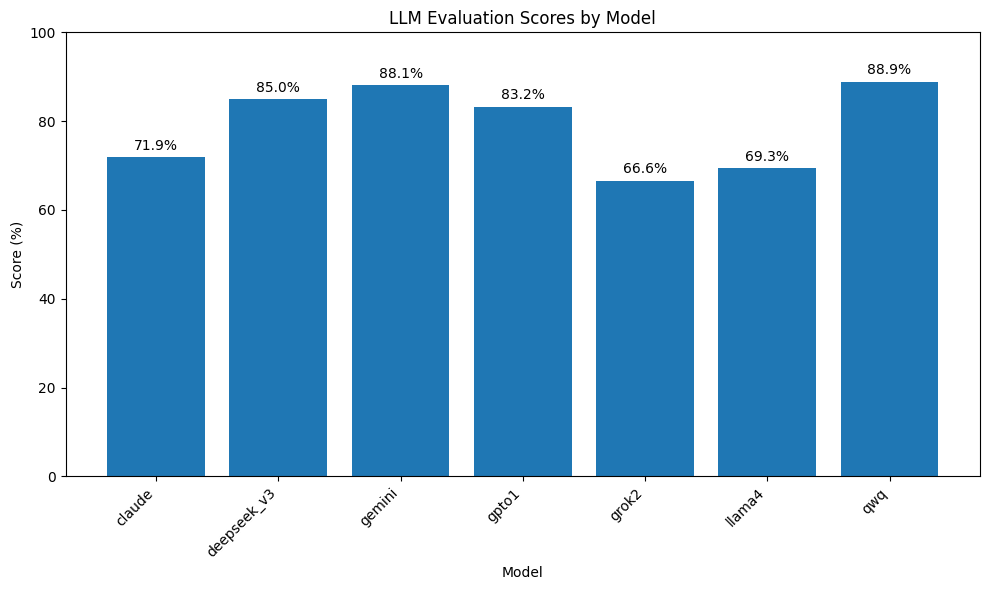

In [192]:
import os
import json
import re
from collections import Counter
import matplotlib.pyplot as plt

# ——— Config ———
RESULT_DIR = "/work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/data/jsonl_judge_results"

# Regex to pull out model name and batch index
pattern = re.compile(r"^judge_requests_(?P<model>.+)_(?P<batch>\d+)_results\.jsonl$")
rating_pattern = re.compile(r"Total rating:\s*(\d+)")

model_scores = {}

for fname in os.listdir(RESULT_DIR):
    m = pattern.match(fname)
    if not m:
        continue

    model_name = m.group('model')
    path       = os.path.join(RESULT_DIR, fname)

    ratings = []
    with open(path, 'r') as f:
        for line in f:
            if not line.strip():
                continue
            _, resp, _ = json.loads(line)
            content    = resp["choices"][0]["message"]["content"]
            rm         = rating_pattern.search(content)
            if rm:
                ratings.append(int(rm.group(1)))

    if not ratings:
        continue

    hist         = Counter(ratings)
    total        = sum(hist.values())
    weighted_sum = sum(score * cnt for score, cnt in hist.items())
    pct_score    = (weighted_sum / (total * 4)) * 100
    model_scores[model_name] = pct_score

# ——— Plot with annotations ———
models = sorted(model_scores.keys())
scores = [model_scores[m] for m in models]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, scores)
plt.xlabel("Model")
plt.ylabel("Score (%)")
plt.title("LLM Evaluation Scores by Model")
plt.ylim(0, 100)
plt.xticks(rotation=45, ha="right")

# Annotate each bar with its percentage value
for bar, score in zip(bars, scores):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,               # offset above the bar
        f"{score:.1f}%",          # one decimal place
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()


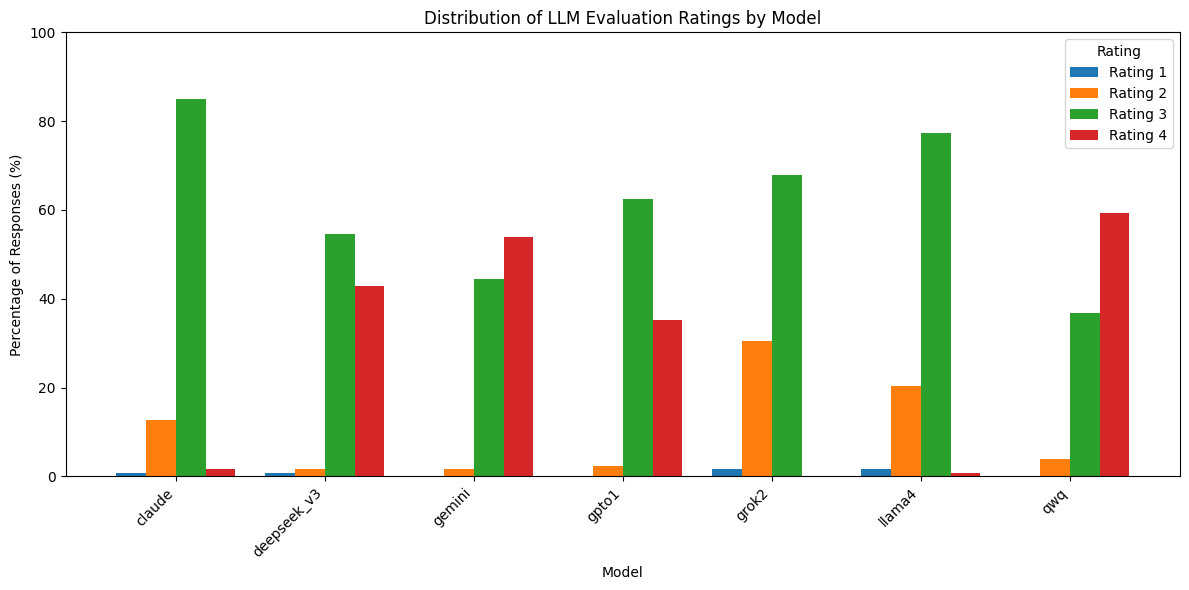

In [73]:
import os
import json
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# ——— Config ———
RESULT_DIR = "/work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/data/jsonl_judge_results"
# Filename pattern to extract model name and batch index
filename_pattern = re.compile(r"^judge_requests_(?P<model>.+)_(?P<batch>\d+)_results\.jsonl$")
# Pattern to extract the rating from each completion
rating_pattern   = re.compile(r"Total rating:\s*(\d+)")

# Collect raw counts per rating for each model
model_counts = {}

for fname in os.listdir(RESULT_DIR):
    match = filename_pattern.match(fname)
    if not match:
        continue

    model_name = match.group("model")
    file_path  = os.path.join(RESULT_DIR, fname)

    # Extract all numeric ratings from this file
    ratings = []
    with open(file_path, "r") as f:
        for line in f:
            if not line.strip():
                continue
            # Each line is a JSON array: [request_obj, response_obj, metadata]
            _, response_obj, _ = json.loads(line)
            content = response_obj["choices"][0]["message"]["content"]
            m = rating_pattern.search(content)
            if m:
                ratings.append(int(m.group(1)))

    # Count how many 1s, 2s, 3s, and 4s we got
    hist = Counter(ratings)
    # Ensure we have entries for all four ratings
    counts = np.array([hist.get(r, 0) for r in [1, 2, 3, 4]], dtype=float)
    model_counts[model_name] = counts

# Convert counts to percentages
models = sorted(model_counts.keys())
counts_matrix = np.vstack([model_counts[m] for m in models])  # shape: (n_models, 4)
totals = counts_matrix.sum(axis=1, keepdims=True)             # total responses per model
percent_matrix = (counts_matrix / totals) * 100               # percentages per rating

# Plot grouped bar chart
x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(12, 6))
for i, rating in enumerate([1, 2, 3, 4]):
    plt.bar(x + i * width, percent_matrix[:, i], width, label=f'Rating {rating}')

plt.xlabel("Model")
plt.ylabel("Percentage of Responses (%)")
plt.title("Distribution of LLM Evaluation Ratings by Model")
plt.ylim(0, 100)
plt.xticks(x + 1.5 * width, models, rotation=45, ha="right")
plt.legend(title="Rating")
plt.tight_layout()
plt.show()


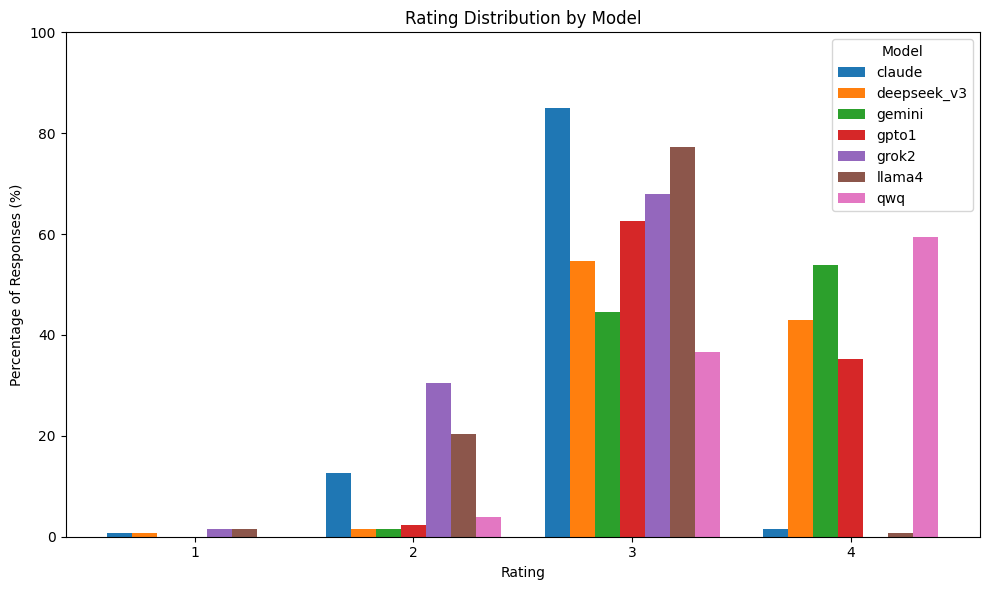

In [74]:
import os
import json
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# ——— Config ———
RESULT_DIR = "/work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/data/jsonl_judge_results"
# capture “judge_requests_<model>_<batch>_results.jsonl”
filename_pattern = re.compile(r"^judge_requests_(?P<model>.+)_(?P<batch>\d+)_results\.jsonl$")
rating_pattern   = re.compile(r"Total rating:\s*(\d+)")

# 1. Aggregate raw counts 1–4 per model
model_counts = {}
for fname in os.listdir(RESULT_DIR):
    m = filename_pattern.match(fname)
    if not m:
        continue
    model_name = m.group("model")
    path = os.path.join(RESULT_DIR, fname)

    ratings = []
    with open(path, "r") as f:
        for line in f:
            if not line.strip(): 
                continue
            _, resp, _ = json.loads(line)
            content = resp["choices"][0]["message"]["content"]
            rm = rating_pattern.search(content)
            if rm:
                ratings.append(int(rm.group(1)))

    hist   = Counter(ratings)
    counts = np.array([hist.get(r, 0) for r in [1, 2, 3, 4]], dtype=float)
    model_counts[model_name] = counts

# 2. Convert to percentages
models       = sorted(model_counts.keys())
counts_mat   = np.vstack([model_counts[m] for m in models])  # shape: (n_models, 4)
totals       = counts_mat.sum(axis=1, keepdims=True)
percent_mat  = (counts_mat / totals) * 100                   # % per rating

# 3. Plot: x = [1,2,3,4], one bar per model per rating
ratings      = np.array([1, 2, 3, 4])
n_models     = len(models)
total_width  = 0.8
bar_width    = total_width / n_models
x_positions  = ratings

plt.figure(figsize=(10, 6))
for i, model in enumerate(models):
    # center the group on each rating
    offset = (i - (n_models - 1) / 2) * bar_width
    plt.bar(x_positions + offset, percent_mat[i], width=bar_width, label=model)

plt.xlabel("Rating")
plt.ylabel("Percentage of Responses (%)")
plt.title("Rating Distribution by Model")
plt.xticks(ratings)
plt.ylim(0, 100)
plt.legend(title="Model")
plt.tight_layout()
plt.show()


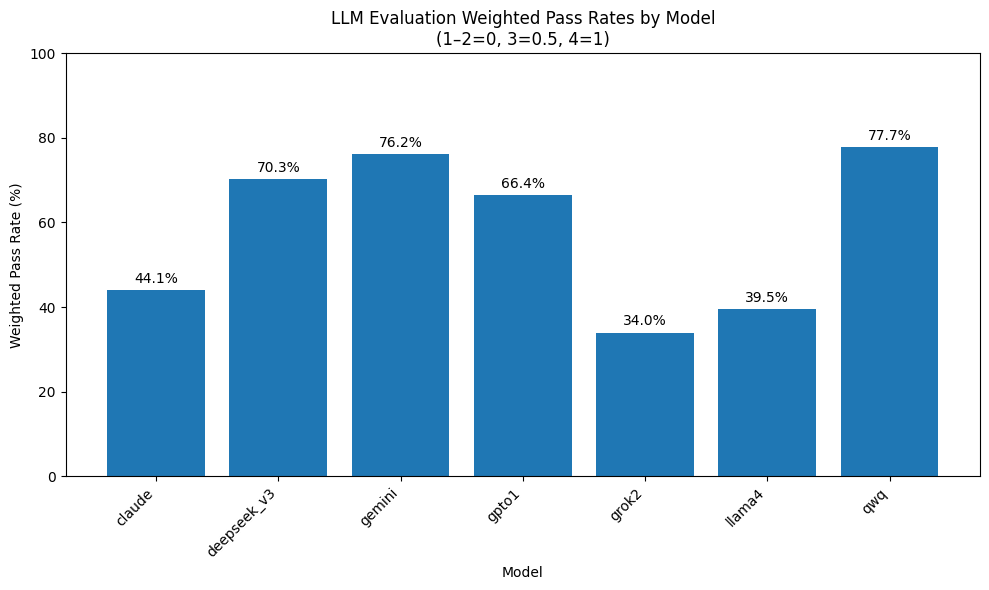

In [50]:
import os
import json
import re
import matplotlib.pyplot as plt

# ——— Config ———
RESULT_DIR = "/work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/data/jsonl_judge_results"

# Regex to pull out model name and batch index
filename_pattern = re.compile(r"^judge_requests_(?P<model>.+)_(?P<batch>\d+)_results\.jsonl$")
rating_pattern  = re.compile(r"Total rating:\s*(\d+)")

model_weighted_rates = {}

for fname in os.listdir(RESULT_DIR):
    m = filename_pattern.match(fname)
    if not m:
        continue

    model_name = m.group("model")
    filepath   = os.path.join(RESULT_DIR, fname)
    ratings = []

    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                _, resp, _ = json.loads(line)
            except json.JSONDecodeError:
                continue
            content = resp.get("choices", [{}])[0] \
                          .get("message", {}) \
                          .get("content", "")
            rm = rating_pattern.search(content)
            if rm:
                ratings.append(int(rm.group(1)))

    if not ratings:
        continue

    total = len(ratings)
    # assign weight: 1–2 → 0, 3 → 0.5, 4 → 1
    weighted_sum = sum(
        0   if r <= 2 else
        0.5 if r == 3 else
        1   for r in ratings
    )
    weighted_rate = (weighted_sum / total) * 100
    model_weighted_rates[model_name] = weighted_rate

# ——— Plot Weighted Pass Rates ———
models       = sorted(model_weighted_rates.keys())
weighted_rates = [model_weighted_rates[m] for m in models]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, weighted_rates)
plt.xlabel("Model")
plt.ylabel("Weighted Pass Rate (%)")
plt.title("LLM Evaluation Weighted Pass Rates by Model\n(1–2=0, 3=0.5, 4=1)")
plt.ylim(0, 100)
plt.xticks(rotation=45, ha="right")

for bar, rate in zip(bars, weighted_rates):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        f"{rate:.1f}%",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()


### Reading All Ground Truth Comments

In [51]:
import json

data = json.load(open("/work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/data/ground_truth.json"))

comments = {}
for idx in range(len(data)):
    question = data[idx]["data"]["processed_question"]
    comments[question] = []
    annotations = data[idx]["annotations"][0]["result"]

    comment_texts = [
        text
        for item in annotations
        if item.get("from_name") == "comment"
        for text in item["value"]["text"]
    ]

    comments[question].extend(comment_texts)

print(comments)

{'How can I protect my kale from wind damage in Montana?': ['Staking is not used with leafy greens. They are not valuable enough to make up for the cost of labor of staking with twine. \nMontana is windier in the fall, not spring: https://www.ktvh.com/news/weather-wise/weather-wise-the-windy-season\n', 'All answers were correct with the exception of staking suggestion and Montana windy season.'], 'What strategies can I use to manage somewhat poorly drained soil after harvesting flowers in Alaska?': ['The answer considered all the possible strategies for managing the poorly drained soils in Alaska. However, in Alaska, the flowers were grown at the garden and field levels. It could be improved by specifically addressing according to these two scenarios.'], 'What parts of wheat are affected by the dirt-colored seed bug in Wyoming?': ['https://pnwhandbooks.org/insect/emerging-insect-pests/emerging-insect/seed-bugs-2001-2005\nThe dirt colored seed bug may eat fallen seeds in a field, but is

### Visualizing Evaluation of Different LLMs – Prompt Version 2


#### Reading Some Responses from LLM as Judge Respose

In [56]:
#!/usr/bin/env python3
"""
Pretty‑print evaluator outputs (Block 1 & Block 2) from JSONL files
inside Jupyter or a normal shell.

Usage in a notebook cell:
    # show first 3 evals for every model
    %run show_evals_nb.py

    # show 5 evals only for models whose name contains "gpt‑4"
    %run show_evals_nb.py --model gpt-4 --max 5
"""
import os, json, re, argparse, sys
from pathlib import Path

# ── CONFIG ──────────────────────────────────────────────────────────────
RESULT_DIR = Path("/work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/data/jsonl_judge_results_p2")
FILE_PAT   = re.compile(r"^judge_requests_(?P<model>.+)_results\.jsonl$")

# ── CLI ARGS (ignore unknown flags like -f) ──────────────────────────────
parser = argparse.ArgumentParser(description="Preview evaluator JSON‑line blocks.", add_help=False)
parser.add_argument("--model", type=str, help="Only show files whose model name contains this substring")
parser.add_argument("--max",   type=int, default=10, help="How many evals to display per file (default = 3)")
args, _unknown = parser.parse_known_args()

# ── helper to print first N json objects from content ───────────────────
def print_block(content: str, n: int):
    shown = 0
    for raw in content.splitlines():
        raw = raw.strip()
        if not raw.startswith("{"):
            continue
        try:
            obj = json.loads(raw)
        except json.JSONDecodeError:
            continue
        print(json.dumps(obj, ensure_ascii=False))
        shown += 1
        if shown >= n:
            break
    if shown == 0:
        print("(no JSON objects found)")

# ── scan & display ──────────────────────────────────────────────────────
for file in sorted(RESULT_DIR.iterdir()):
    m = FILE_PAT.match(file.name)
    if not m:
        continue
    model_name = m.group("model")
    if args.model and args.model not in model_name:
        continue

    print("=" * 80)
    print(f"MODEL: {model_name}  |  FILE: {file.name}")

    with file.open(encoding="utf-8") as f:
        shown = 0
        for line_no, line in enumerate(f, 1):
            if not line.strip():
                continue
            try:
                _prompt, resp, _meta = json.loads(line)
            except (ValueError, json.JSONDecodeError):
                continue

            content = resp["choices"][0]["message"]["content"]
            print(f"\n— Evaluation #{line_no} —")
            print_block(content, args.max)
            shown += 1
            if shown >= args.max:
                break


MODEL: claude  |  FILE: judge_requests_claude_results.jsonl

— Evaluation #1 —
{"sentence": "Install drip irrigation for efficient, targeted moisture delivery", "label": "supported", "rationale": "The ground-truth specifically recommends drip irrigation to deliver water directly to roots, minimizing waste and boron buildup.", "excerpt": "Drip Irrigation: Deliver water directly to roots, minimizing waste and boron buildup."}
{"sentence": "Consider soil moisture sensors to optimize irrigation timing and amounts", "label": "supported", "rationale": "The ground-truth mentions using soil moisture sensors to schedule irrigation based on real-time soil conditions.", "excerpt": "Soil Moisture Sensors: Use technology to schedule irrigation based on real-time soil conditions."}
{"sentence": "Schedule irrigation based on crop growth stages, avoiding excess during curing", "label": "unsupported", "rationale": "The ground-truth discusses adjusting irrigation based on real-time soil moisture and wea

#### Visualization Considering Missing Facts W/O Threshold

In [74]:
#!/usr/bin/env python3
import os
import json
import re
import numpy as np
import pandas as pd

# ── CONFIG ───────────────────────────────────────────────────────────────
RESULT_DIR = "/work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/data/jsonl_judge_results_100_p2"
FILE_PAT   = re.compile(r"^judge_requests_(?P<model>.+)_results\.jsonl$")

# ── PARAMETERS ────────────────────────────────────────────────────────────
THRESHOLD = 0.80   # F1 must exceed this to count as a “pass”

# ── CATEGORY REMAP ────────────────────────────────────────────────────────
TEMPLATE_REMAP = {
    "Management":        "Crop Inputs",
    "Crop":              "Crop Management",
    "Nutrients":         "Plant & Seed Health",
    "In-Season Other":   "Plant & Seed Health",
    "Outside-Season":    "Plant & Seed Health",
    "Abiotic Nutrients": "Plant & Seed Health",
    "Abiotic Nutrient":  "Plant & Seed Health",
}

# ── MODEL DISPLAY NAMES ───────────────────────────────────────────────────
DISPLAY_NAMES = {
    "gemini2.5-flash":  "Gemini 2.5 Flash",
    "grok-3-beta":      "Grok-3 Beta",
    "gpt01":            "GPT-o1",
    "QwQ-32B":          "QwQ-32B",
    "deepseek_v3":      "DeepSeek V3",
    "llama4_maverick":  "LLaMA-4 Maverick",
    "llama4_scout":     "LLaMA-4 Scout",
    "llama3":           "LLaMA-3",
    "gpt4o":            "GPT-4o",
    "mistral_24B":      "Mistral 24B",
    "mistral_7B":       "Mistral 7B",
    "mistral_7b_sft":   "Mistral 7B (SFT)",
    "phi3_sft":         "Phi-3 (SFT)",
    "phi-3-8b":         "Phi-3",
    "grok-2":           "Grok-2",
}

def count_confusion(content: str):
    """Count supported vs unsupported/contradictory vs missing facts in the judge output."""
    sup = unsup = missing = 0
    for line in content.splitlines():
        line = line.lstrip()
        if not line.startswith("{"):
            continue
        try:
            obj = json.loads(line)
        except json.JSONDecodeError:
            continue

        if "sentence" in obj:
            lbl = obj.get("label")
            if lbl == "supported":
                sup += 1
            elif lbl in ("unsupported", "contradictory"):
                unsup += 1
        elif "missing_fact" in obj:
            missing += 1

    return sup, unsup, missing

# ── GATHER PASS/FAIL DATA ─────────────────────────────────────────────────
records = []
for fn in os.listdir(RESULT_DIR):
    m = FILE_PAT.match(fn)
    if not m:
        continue
    model = m.group("model")
    path = os.path.join(RESULT_DIR, fn)
    with open(path, encoding="utf-8") as f:
        for line in f:
            if not line.strip():
                continue
            try:
                _req, resp, meta = json.loads(line)
            except json.JSONDecodeError:
                continue
            content = resp["choices"][0]["message"]["content"]
            tp, fp, fn_ = count_confusion(content)

            precision = tp / (tp + fp) if (tp + fp) else 0
            recall    = tp / (tp + fn_) if (tp + fn_) else 0
            f1        = (2 * precision * recall / (precision + recall)) if (precision + recall) else 0

            records.append({
                "model":    model,
                "template": meta.get("template_column", ""),
                "passed":   f1 >= THRESHOLD
            })

df = pd.DataFrame(records)

# ── PIVOT TO PASS RATE MATRIX ────────────────────────────────────────────
pivot_pass = df.pivot_table(
    index="template",
    columns="model",
    values="passed",
    aggfunc="mean"
).fillna(0)

# Apply category remapping
pivot_pass.index = pivot_pass.index.map(lambda t: TEMPLATE_REMAP.get(t, t))

# ── BUILD AND PRINT SUMMARY TABLE ────────────────────────────────────────
summary = pivot_pass.T.copy()               # now index=models
summary['Overall'] = summary.mean(axis=1)

# Apply display names for models
summary.index = summary.index.map(lambda m: DISPLAY_NAMES.get(m, m))

# Print as markdown table
print(
    summary
    .reset_index()
    .rename(columns={'index': 'Model'})
    .to_markdown(index=False)
)


| model            |   Abiotic Harvest Questions |   Abiotic Nutrients Questions |   Abiotic Soil Questions |   Abiotic Weather Questions |   Biotic Diseases Questions |   Biotic Insects Questions |   Biotic Weeds Questions |   Cover Crop Questions |   Crop Questions |   Management Questions |   Overall |
|:-----------------|----------------------------:|------------------------------:|-------------------------:|----------------------------:|----------------------------:|---------------------------:|-------------------------:|-----------------------:|-----------------:|-----------------------:|----------:|
| QwQ-32B          |                         0   |                           0   |                      0.2 |                         0.2 |                         0.1 |                        0   |                      0   |                    0   |              0   |                    0   |      0.05 |
| DeepSeek V3      |                         0.2 |                           0 

Saved: per‑template_pass_rate_(f1_ge_0.8).pdf


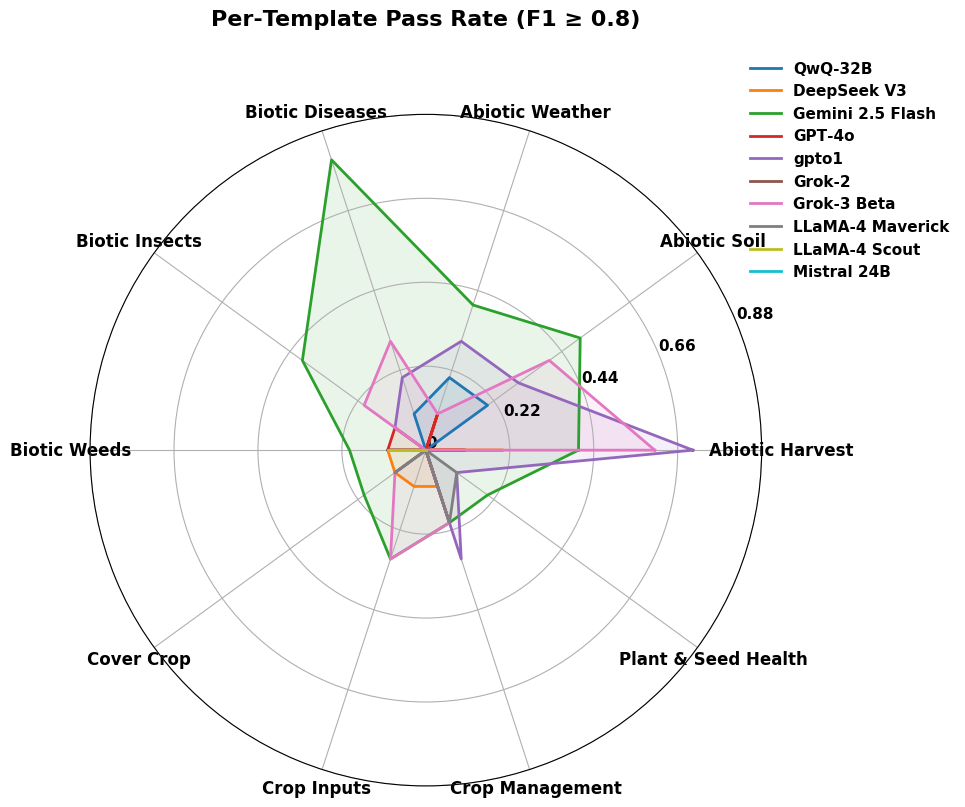

Saved: per‑template_pass_rate_(f1_ge_0.8)_–_sft_models.pdf


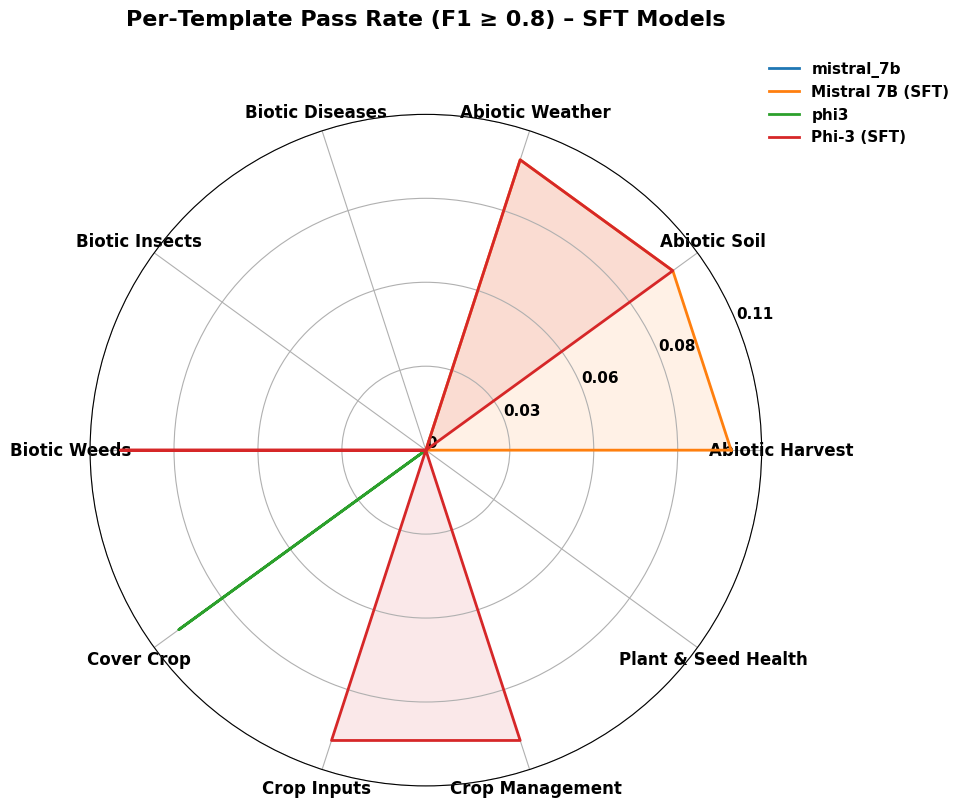

In [73]:
#!/usr/bin/env python3
"""
Per‑template pass‑rate (F1 ≥ 0.80) radar charts.

• Removes the trailing “… Question(s)” token from every template name.
• Then applies the requested merges / renames:
        Management           → Crop Inputs
        Crop                 → Crop Management
        Nutrients            → Plant & Seed Health
        In‑Season Other      → Plant & Seed Health
        Outside‑Season       → Plant & Seed Health
• Draws two figures:
        – “Others”   (all models that are *not* in the Phi family)
        – “Phi family” (Phi‑3, Mistral‑7B, LLaMA‑3 variants)
• Labels, ticks, and legend text are larger and bold.
"""

import os
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ── CONFIG ───────────────────────────────────────────────────────────────
RESULT_DIR = (
    "/work/mech-ai-scratch/zare/Prompt_creation/"
    "llm-judge-stage1/data/jsonl_judge_results_100_p2"
)
FILE_PAT = re.compile(r"^judge_requests_(?P<model>.+)_results\.jsonl$")

FIG_DIR = (
    "/work/mech-ai-scratch/zare/Prompt_creation/"
    "llm-judge-stage1/data/figures"
)
os.makedirs(FIG_DIR, exist_ok=True)

THRESHOLD = 0.80   # F1 must exceed this to count as a “pass”


# ── FRIENDLY MODEL NAMES ────────────────────────────────────────────────
DISPLAY_NAMES = {
    "gemini2.5-flash": "Gemini 2.5 Flash",
    "grok-3-beta":     "Grok‑3 Beta",
    "gpt01":           "GPT‑o1",
    "QwQ-32B":         "QwQ‑32B",
    "deepseek_v3":     "DeepSeek V3",
    "llama4_maverick": "LLaMA‑4 Maverick",
    "llama4_scout":    "LLaMA‑4 Scout",
    "llama3":          "LLaMA‑3",
    "gpt4o":           "GPT‑4o",
    "mistral_24B":     "Mistral 24B",
    "mistral_7B":      "Mistral 7B",
    "mistral_7b_sft":  "Mistral 7B (SFT)",
    "phi3_sft":        "Phi‑3 (SFT)",
    "phi-3-8b":        "Phi‑3",
    "grok-2":          "Grok‑2",
}

# ── TEMPLATE MERGE / RENAME MAP ─────────────────────────────────────────

TEMPLATE_REMAP = {
     "Management":       "Crop Inputs",
     "Crop":             "Crop Management",
     "Nutrients":        "Plant & Seed Health",
     "In-Season Other":  "Plant & Seed Health",
     "Outside-Season":   "Plant & Seed Health",
    "Abiotic Nutrients": "Plant & Seed Health",   # ← NEW
   "Abiotic Nutrient":  "Plant & Seed Health",   # ← (covers singular form)
 }


_SUFFIX_PAT = re.compile(r"\s*Questions?$", flags=re.IGNORECASE)

def canonical_template(raw: str) -> str:
    """
    1. Strip a trailing “… Question” or “… Questions”.
    2. Apply merge/rename table.
    """
    if not raw:
        return raw
    base = _SUFFIX_PAT.sub("", raw)           # drop suffix
    return TEMPLATE_REMAP.get(base, base)     # merge / rename if needed


# ── PARSE JUDGE OUTPUT ──────────────────────────────────────────────────
def count_confusion(content: str):
    """Return (supported, unsupported+contradictory, missing)."""
    sup = unsup_contr = miss = 0
    for line in content.splitlines():
        line = line.lstrip()
        if not line.startswith("{"):
            continue
        try:
            obj = json.loads(line)
        except json.JSONDecodeError:
            continue
        if "sentence" in obj:
            lbl = obj.get("label")
            if lbl == "supported":
                sup += 1
            elif lbl in ("unsupported", "contradictory"):
                unsup_contr += 1
        elif "missing_fact" in obj:
            miss += 1
    return sup, unsup_contr, miss


# ── LOAD & AGGREGATE ────────────────────────────────────────────────────
records = []
for file in os.listdir(RESULT_DIR):
    m = FILE_PAT.match(file)
    if not m:
        continue
    model_id = m.group("model")

    with open(os.path.join(RESULT_DIR, file), encoding="utf-8") as f:
        for line in f:
            if not line.strip():
                continue
            try:
                _req, resp, meta = json.loads(line)
            except json.JSONDecodeError:
                continue

            tp, fp, fn_ = count_confusion(
                resp["choices"][0]["message"]["content"]
            )
            prec = tp / (tp + fp) if (tp + fp) else 0
            rec  = tp / (tp + fn_) if (tp + fn_) else 0
            f1   = 2 * prec * rec / (prec + rec) if (prec + rec) else 0

            records.append({
                "model":    model_id,
                "template": canonical_template(meta.get("template_column", "")),
                "passed":   f1 >= THRESHOLD,
            })

df = pd.DataFrame(records)

pivot_pass = df.pivot_table(
    index="template",
    columns="model",
    values="passed",
    aggfunc="mean"
).fillna(0)

templates = pivot_pass.index.tolist()
models    = pivot_pass.columns.tolist()

# ── GROUPING: Phi family vs others ───────────────────────────────────────
PHI_ROOTS    = ("phi3", "phi-3")
MISTRAL_ROOT = "mistral_7b"
LLAMA3_ROOT  = "llama3"

def in_phi_family(mid: str) -> bool:
    return (mid.startswith(PHI_ROOTS) or
            mid.startswith(MISTRAL_ROOT) or
            mid.startswith(LLAMA3_ROOT))

phi_family = [m for m in models if in_phi_family(m)]
others     = [m for m in models if m not in phi_family]

# ── RADAR PLOT HELPER ────────────────────────────────────────────────────
def plot_radar(dataframe, model_ids, title):
    if not model_ids:
        print(f"[skip] {title}: no models")
        return

    N = len(templates)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    fig = plt.figure(figsize=(10, 10))
    ax  = fig.add_subplot(111, polar=True)

    for mid in model_ids:
        values = dataframe[mid].tolist() + dataframe[mid].tolist()[:1]
        ax.plot(angles, values,
                label=DISPLAY_NAMES.get(mid, mid),
                linewidth=2)
        ax.fill(angles, values, alpha=0.1)

    # bigger, bold tick labels
    ax.set_thetagrids(
        np.degrees(angles[:-1]),
        templates,
        fontsize=12,
        fontweight='bold',
    )

    ymax = dataframe[model_ids].values.max()
    ymax = ymax * 1.10 if ymax else 1.0
    ax.set_ylim(0, ymax)
    ax.set_yticks(np.linspace(0, ymax, 5))
    ax.set_yticklabels(
        [f"{x:.2f}" if x else "0" for x in np.linspace(0, ymax, 5)],
        fontsize=11,
        fontweight='bold'
    )

    ax.set_title(title, y=1.12, fontsize=16, fontweight='bold')
    leg = ax.legend(
        loc="upper right",
        bbox_to_anchor=(1.30, 1.10),
        fontsize=11,
        frameon=False
    )
    for txt in leg.get_texts():
        txt.set_fontweight('bold')

    plt.tight_layout()
    safe = title.lower().replace(" ", "_").replace("≥", "ge")
    fig.savefig(os.path.join(FIG_DIR, f"{safe}.pdf"), dpi=300)
    print(f"Saved: {safe}.pdf")
    plt.show()


# ── DRAW FIGURES ─────────────────────────────────────────────────────────
plot_radar(pivot_pass, others,
           f"Per‑Template Pass Rate (F1 ≥ {THRESHOLD})")

plot_radar(pivot_pass, phi_family,
           f"Per‑Template Pass Rate (F1 ≥ {THRESHOLD}) – SFT Models")


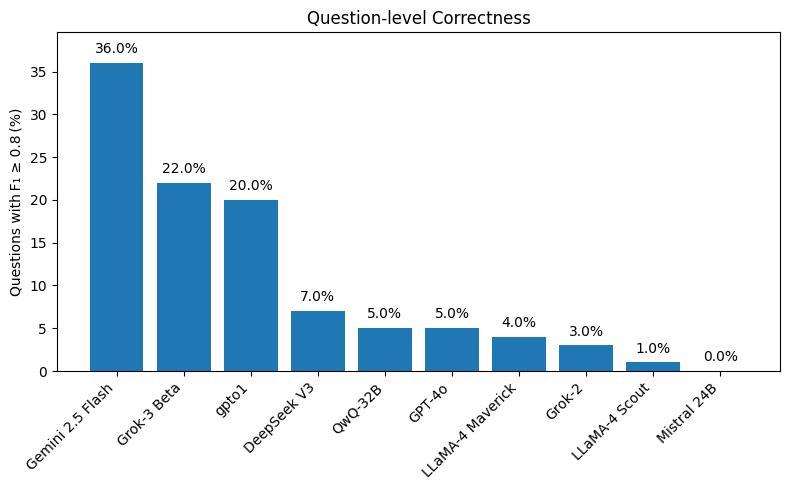

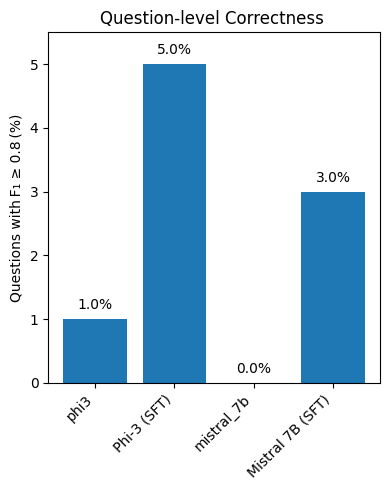

In [62]:
#!/usr/bin/env python3
"""
Aggregate question‑level F1 scores from LLM‑Judge results and plot the
percentage of questions each model answers “well” (F1 ≥ 0.8).

• Bars use friendly names (DISPLAY_NAMES).
• “Phi Family” chart groups siblings together:           ┌─► Phi‑3
      Phi‑3  &  Phi‑3 (SFT)   side‑by‑side               └─► Phi‑3 (SFT)
      Mistral 7B & Mistral 7B (SFT)  … etc.
"""

import os, json, re
from collections import defaultdict
import matplotlib.pyplot as plt


# ── CONFIG ───────────────────────────────────────────────────────────────
RESULT_DIR = (
    "/work/mech-ai-scratch/zare/Prompt_creation/"
    "llm-judge-stage1/data/jsonl_judge_results_100_p2"
)
FILE_PAT = re.compile(r"^judge_requests_(?P<model>.+)_results\.jsonl$")

FIG_DIR = (
    "/work/mech-ai-scratch/zare/Prompt_creation/"
    "llm-judge-stage1/data/figures"
)
os.makedirs(FIG_DIR, exist_ok=True)


# ── FRIENDLY DISPLAY NAMES ───────────────────────────────────────────────
DISPLAY_NAMES = {
    "gemini2.5-flash": "Gemini 2.5 Flash",
    "grok-3-beta":     "Grok‑3 Beta",
    "gpt01":           "GPT‑o1",
    "QwQ-32B":         "QwQ‑32B",
    "deepseek_v3":     "DeepSeek V3",
    "llama4_maverick": "LLaMA‑4 Maverick",
    "llama4_scout":    "LLaMA‑4 Scout",
    "llama3":          "LLaMA‑3",
    "gpt4o":           "GPT‑4o",
    "mistral_24B":     "Mistral 24B",
    "mistral_7B":      "Mistral 7B",
    "mistral_7b_sft":  "Mistral 7B (SFT)",
    "phi3_sft":        "Phi‑3 (SFT)",
    "phi-3-8b":        "Phi‑3",
    "grok-2":          "Grok‑2",
}


# ── helper to count confusion metrics ────────────────────────────────────
def count_confusion(content: str):
    """Return (supported, unsupported, contradictory, missing)."""
    sup = unsup = contrad = missing = 0
    for line in content.splitlines():
        line = line.lstrip()
        if not line.startswith("{"):
            continue
        try:
            obj = json.loads(line)
        except json.JSONDecodeError:
            continue
        if "sentence" in obj:
            lbl = obj.get("label")
            if   lbl == "supported":      sup     += 1
            elif lbl == "unsupported":    unsup   += 1
            elif lbl == "contradictory":  contrad += 1
        elif "missing_fact" in obj:
            missing += 1
    return sup, unsup, contrad, missing


# ── aggregate question‑level correctness ────────────────────────────────
correctness = defaultdict(lambda: {"correct": 0, "total": 0})

for fname in os.listdir(RESULT_DIR):
    m = FILE_PAT.match(fname)
    if not m:
        continue
    model_id = m.group("model")
    with open(os.path.join(RESULT_DIR, fname), encoding="utf-8") as f:
        for line in f:
            if not line.strip():
                continue
            try:
                _, resp, _ = json.loads(line)
            except (ValueError, json.JSONDecodeError):
                continue

            sup, unsup, contrad, miss = count_confusion(
                resp["choices"][0]["message"]["content"]
            )
            tp, fp, fn = sup, (unsup + contrad), miss
            prec = tp / (tp + fp) if (tp + fp) else 0
            rec  = tp / (tp + fn) if (tp + fn) else 0
            f1   = 2 * prec * rec / (prec + rec) if (prec + rec) else 0

            correctness[model_id]["total"] += 1
            if f1 >= 0.8:
                correctness[model_id]["correct"] += 1


# ── GROUP DEFINITIONS ───────────────────────────────────────────────────
PHI_ROOTS   = ("phi3", "phi-3")
MISTRAL_ROOT = "mistral_7b"
LLAMA3_ROOT  = "llama3"

def get_root(mid: str) -> str:
    """Map variant IDs to a common family root."""
    if mid.startswith(PHI_ROOTS):     return "phi3"
    if mid.startswith(MISTRAL_ROOT):  return "mistral_7b"
    if mid.startswith(LLAMA3_ROOT):   return "llama3"
    return mid  # fallback


phi_family_stats = {
    m: s for m, s in correctness.items()
    if m.startswith((*PHI_ROOTS, MISTRAL_ROOT, LLAMA3_ROOT))
}
others_stats = {
    m: s for m, s in correctness.items() if m not in phi_family_stats
}


# ── PLOTTING ─────────────────────────────────────────────────────────────
def plot_correctness(group_stats, title, keep_siblings_together=False):
    if not group_stats:
        print(f"[skipping] no data for: {title}")
        return

    if keep_siblings_together:
        # custom sort: first by root order, then base→variant (SFT last)
        ROOT_ORDER = ["phi3", "mistral_7b", "llama3"]
        def sort_key(item):
            mid, stats = item
            root_idx = ROOT_ORDER.index(get_root(mid)) \
                       if get_root(mid) in ROOT_ORDER else len(ROOT_ORDER)
            variant_idx = 0 if "sft" not in mid.lower() else 1
            return (root_idx, variant_idx)
        sorted_models = sorted(group_stats.items(), key=sort_key)
    else:
        # default: sort by performance %
        sorted_models = sorted(
            group_stats.items(),
            key=lambda kv: kv[1]["correct"] / kv[1]["total"],
            reverse=True,
        )

    model_ids = [mid for mid, _ in sorted_models]
    labels    = [DISPLAY_NAMES.get(mid, mid) for mid in model_ids]
    pct_corr  = [stats["correct"]/stats["total"]*100 for _, stats in sorted_models]

    plt.figure(figsize=(max(4, len(labels)*0.8), 5))
    bars = plt.bar(labels, pct_corr)
    plt.ylabel("Questions with F₁ ≥ 0.8 (%)")
    plt.title(title)
    ymax = max(pct_corr) * 1.10 if pct_corr else 1
    plt.ylim(0, ymax)
    plt.xticks(rotation=45, ha="right")
    for bar, pct in zip(bars, pct_corr):
        plt.text(bar.get_x()+bar.get_width()/2, pct + ymax*0.02,
                 f"{pct:.1f}%", ha="center", va="bottom")
    plt.tight_layout()

    safe = title.lower().replace(" ", "_").replace("≥", "ge").replace("₁","1")
    for ext in ("pdf", "png"):
        plt.savefig(os.path.join(FIG_DIR, f"{safe}.{ext}"),
                    format=ext, dpi=300, bbox_inches="tight")
    plt.show()


plot_correctness(others_stats, "Question‑level Correctness")
plot_correctness(phi_family_stats,
                 "Question‑level Correctness ",
                 keep_siblings_together=True)


In [6]:
# ── ADD THIS AFTER YOUR existing plot_correctness(...) ────────────────────
from statistics import mean
import textwrap

def accumulate_metrics_with_score(result_dir, file_pat, threshold=0.75):
    """
    Reads your JSONL outputs and for each model accumulates:
      – tp, fp_u, fp_c, fn
      – total facts and per-question counts
      – score_count = #questions with F1 > threshold
      – q_tot = total #questions
    """
    metrics = defaultdict(lambda: defaultdict(int))

    for fname in os.listdir(result_dir):
        m = file_pat.match(fname)
        if not m:
            continue
        model = m.group("model")
        path  = os.path.join(result_dir, fname)
        with open(path, encoding="utf-8") as f:
            for line in f:
                if not line.strip():
                    continue
                try:
                    _, resp, _ = json.loads(line)
                except (ValueError, json.JSONDecodeError):
                    continue
                content = resp["choices"][0]["message"]["content"]
                sup, unsup, contrad, miss = count_confusion(content)

                tp = sup
                fp = unsup + contrad
                fn = miss

                mt = metrics[model]
                mt['tp']        += tp
                mt['fp_u']      += unsup
                mt['fp_c']      += contrad
                mt['fn']        += miss
                mt['facts_tot'] += (sup + unsup + contrad + miss)

                # compute per-question F1 for scoring
                prec = tp / (tp + fp) if (tp + fp) else 0.0
                rec  = tp / (tp + fn) if (tp + fn) else 0.0
                q_f1 = (2 * prec * rec / (prec + rec)) if (prec + rec) else 0.0
                if q_f1 > threshold:
                    mt['score_count'] += 1

                mt['q_tot'] += 1

    return metrics


def finalize_metrics(mt):
    """Compute precision, recall, averages, and Score in-place."""
    tp    = mt['tp']
    fp    = mt['fp_u'] + mt['fp_c']
    fn    = mt['fn']
    mt['precision'] = tp / (tp + fp) if (tp + fp) else 0.0
    mt['recall']    = tp / (tp + fn) if (tp + fn) else 0.0
    mt['avg_facts'] = mt['facts_tot'] / mt['q_tot'] if mt['q_tot'] else 0.0
    mt['avg_miss']  = mt['fn'] / mt['q_tot'] if mt['q_tot'] else 0.0
    mt['score']     = mt['score_count'] / mt['q_tot'] if mt['q_tot'] else 0.0


def latex_table(group_metrics, caption, label):
    """
    Build a LaTeX table (booktabs style) with columns:
      Model, TP, FP_u, FP_c, FN,
      Precision, Recall, AvgFacts, AvgMiss, Score
    Best value in each column → \\textbf{…}, second-best → \\underline{…}.
    """
    # finalize
    for mt in group_metrics.values():
        finalize_metrics(mt)

    # define sort direction for highlighting
    higher_is_better = {
        'tp': True, 'fp_u': False, 'fp_c': False, 'fn': False,
        'precision': True, 'recall': True,
        'avg_facts': True, 'avg_miss': False, 'score': True
    }
    columns = ['tp','fp_u','fp_c','fn','precision','recall','avg_facts','avg_miss','score']

    # collect values per column
    col_vals = {c: [mt[c] for mt in group_metrics.values()] for c in columns}
    best, second = {}, {}
    for c, vals in col_vals.items():
        if not vals: continue
        vals_sorted = sorted(vals, reverse=higher_is_better[c])
        best[c]   = vals_sorted[0]
        second[c] = vals_sorted[1] if len(vals_sorted) > 1 else None

    def fmt(v):
        return f"{v:.3f}" if isinstance(v, float) else str(v)

    def decorate(c, v):
        if v == best[c]:
            return r"\textbf{" + fmt(v) + "}"
        if second[c] is not None and v == second[c]:
            return r"\underline{" + fmt(v) + "}"
        return fmt(v)

    # build rows
    rows = []
    for model, mt in sorted(group_metrics.items(),
                            key=lambda kv: kv[1]['score'],
                            reverse=True):
        cells = [model] + [decorate(c, mt[c]) for c in columns]
        rows.append(" & ".join(cells) + r" \\")
    body = "\n".join(rows)

    return textwrap.dedent(f"""
    \\begin{{table}}[h!]
    \\centering
    \\small
    \\setlength{{\\tabcolsep}}{{4pt}}
    \\begin{{tabular}}{{lrrrrrrrrr}}
    \\toprule
    Model & TP & FP\\_u & FP\\_c & FN & Precision & Recall & AvgFacts & AvgMiss & Score \\\\
    \\midrule
    {body}
    \\bottomrule
    \\end{{tabular}}
    \\caption{{{caption}}}
    \\label{{tab:{label}}}
    \\end{{table}}
    """).strip()


# ── MAIN ────────────────────────────────────────────────────────────────
metrics = accumulate_metrics_with_score(RESULT_DIR, FILE_PAT, threshold=0.75)
phi3_group  = {m: mt for m, mt in metrics.items() if m.startswith("phi3")}
other_group = {m: mt for m, mt in metrics.items() if not m.startswith("phi3")}

if other_group:
    print(latex_table(other_group,
          "Per-model breakdown (non-Phi-3).",
          "others_metrics"))
    print()

if phi3_group:
    print(latex_table(phi3_group,
          "Per-model breakdown (Phi-3 family).",
          "phi3_metrics"))
else:
    print("⚠️ No models starting with 'phi3' found.")


\begin{table}[h!]
    \centering
    \small
    \setlength{\tabcolsep}{4pt}
    \begin{tabular}{lrrrrrrrrr}
    \toprule
    Model & TP & FP\_u & FP\_c & FN & Precision & Recall & AvgFacts & AvgMiss & Score \\
    \midrule
    gemini2.5-flash & \underline{1449} & 616 & 32 & \underline{452} & \textbf{0.691} & \underline{0.762} & 28.966 & \underline{5.136} & \textbf{0.455} \\
grok-3-beta & \textbf{1816} & 1238 & 70 & \textbf{346} & 0.581 & \textbf{0.840} & \textbf{39.432} & \textbf{3.932} & \underline{0.364} \\
gpto1 & 1141 & 591 & 38 & 462 & \underline{0.645} & 0.712 & 25.364 & 5.250 & 0.318 \\
llama4_maverick & 844 & 591 & 41 & 579 & 0.572 & 0.593 & 23.352 & 6.580 & 0.114 \\
QwQ-32B & 1076 & 1032 & 47 & 487 & 0.499 & 0.688 & \underline{30.023} & 5.534 & 0.102 \\
llama4_scout & 719 & 667 & 84 & 601 & 0.489 & 0.545 & 23.534 & 6.830 & 0.068 \\
deepseek_v3 & 833 & 743 & 40 & 468 & 0.515 & 0.640 & 23.682 & 5.318 & 0.057 \\
grok-2 & 779 & 836 & 42 & 579 & 0.470 & 0.574 & 25.409 & 6.580 & 0.0

In [57]:
# --- COLOUR‑CODED LaTeX TABLE (pretty names + robust shading) ----------
# Needs:  \usepackage[table,dvipsnames]{xcolor}  in your .tex preamble
import textwrap, json, os, re
from collections import defaultdict

# Which raw IDs mark the “reasoning” models
RAW_REASONING_IDS = {
    "gemini2.5-flash",
    "grok-3-beta",
    "gpto1",
    "QwQ-32B",
}
ROW_COLOUR = "Peach!20"        # any xcolor‑named colour (or define your own)

# 1️⃣  ACCUMULATE METRICS -------------------------------------------------
def accumulate(dir_path, file_pat, th=0.80):
    m = defaultdict(lambda: defaultdict(int))
    for fn in os.listdir(dir_path):
        mo = file_pat.match(fn)
        if not mo:
            continue
        mid = mo.group("model")
        for line in open(os.path.join(dir_path, fn), encoding="utf-8"):
            if not line.strip():
                continue
            try:
                _, resp, _ = json.loads(line)
            except Exception:
                continue
            sup, unsup, contrad, miss = count_confusion(
                resp["choices"][0]["message"]["content"]
            )
            tp, fp, fn = sup, unsup + contrad, miss
            prec = tp / (tp + fp) if (tp + fp) else 0.0
            rec  = tp / (tp + fn) if (tp + fn) else 0.0
            f1   = 2*prec*rec/(prec+rec) if (prec+rec) else 0.0
            mt = m[mid]
            mt["tp"]   += tp
            mt["fp"]   += fp
            mt["fn"]   += fn
            mt["pass"] += (f1 >= th)
            mt["tot"]  += 1
    for mt in m.values():
        tp, fp, fn = mt["tp"], mt["fp"], mt["fn"]
        mt["precision"] = tp / (tp + fp) if (tp+fp) else 0.0
        mt["recall"]    = tp / (tp + fn) if (tp+fn) else 0.0
        mt["score"]     = mt["pass"] / mt["tot"] if mt["tot"] else 0.0
    return m


# 2️⃣  BUILD LATEX TABLE --------------------------------------------------
def latex_table(metrics, caption, label):
    # Convert the raw‑ID set to pretty names so the colour test lines up
    PRETTY_REASONING = {DISPLAY_NAMES.get(mid, mid) for mid in RAW_REASONING_IDS}

    # Sort rows by Score desc
    rows = sorted(metrics.items(), key=lambda kv: kv[1]["score"], reverse=True)

    lines = []
    for mid, mt in rows:
        pretty = DISPLAY_NAMES.get(mid, mid)            # guaranteed mapping
        row_pref = f"\\rowcolor{{{ROW_COLOUR}}}\n" if pretty in PRETTY_REASONING else ""
        lines.append(
            row_pref +
            f"{pretty} & {mt['score']*100:.1f}\\% & "
            f"{mt['precision']:.3f} & {mt['recall']:.3f} \\\\"
        )

    body = "\n".join(lines)

    return textwrap.dedent(f"""
    % Requires \\usepackage[table,dvipsnames]{{xcolor}}
    \\begin{{table}}[h!]
    \\centering
    \\small
    \\begin{{tabular}}{{lccc}}
    \\toprule
    Model & Score (F$_1$$>$0.80) & Precision & Recall \\\\
    \\midrule
    {body}
    \\bottomrule
    \\end{{tabular}}
    \\caption{{{caption}\\newline
      \\textit{{Rows shaded in {ROW_COLOUR} highlight reasoning‑oriented models
      (Gemini 2.5 Flash, Grok‑3 Beta, GPT‑o1, QwQ‑32B).}}}}
    \\label{{tab:{label}}}
    \\end{{table}}
    """).strip()


# 3️⃣  MAIN ---------------------------------------------------------------
metrics_all = accumulate(RESULT_DIR, FILE_PAT, th=0.80)

print(
    latex_table(
        metrics_all,
        "Per‑model benchmark performance.",
        "all_models_metrics"
    )
)


% Requires \usepackage[table,dvipsnames]{xcolor}
    \begin{table}[h!]
    \centering
    \small
    \begin{tabular}{lccc}
    \toprule
    Model & Score (F$_1$$>$0.80) & Precision & Recall \\
    \midrule
    \rowcolor{Peach!20}
Gemini 2.5 Flash & 36.0\% & 0.727 & 0.778 \\
\rowcolor{Peach!20}
Grok‑3 Beta & 22.0\% & 0.583 & 0.815 \\
\rowcolor{Peach!20}
gpto1 & 20.0\% & 0.654 & 0.710 \\
DeepSeek V3 & 7.0\% & 0.544 & 0.644 \\
Phi‑3 (SFT) & 5.0\% & 0.474 & 0.598 \\
\rowcolor{Peach!20}
QwQ‑32B & 5.0\% & 0.505 & 0.693 \\
GPT‑4o & 5.0\% & 0.554 & 0.558 \\
LLaMA‑4 Maverick & 4.0\% & 0.596 & 0.593 \\
Mistral 7B (SFT) & 3.0\% & 0.470 & 0.678 \\
Grok‑2 & 3.0\% & 0.466 & 0.575 \\
LLaMA‑4 Scout & 1.0\% & 0.480 & 0.523 \\
phi3 & 1.0\% & 0.441 & 0.472 \\
Mistral 24B & 0.0\% & 0.442 & 0.557 \\
mistral_7b & 0.0\% & 0.408 & 0.520 \\
    \bottomrule
    \end{tabular}
    \caption{Per‑model benchmark performance.\newline
      \textit{Rows shaded in Peach!20 highlight reasoning‑oriented models
      (Gem

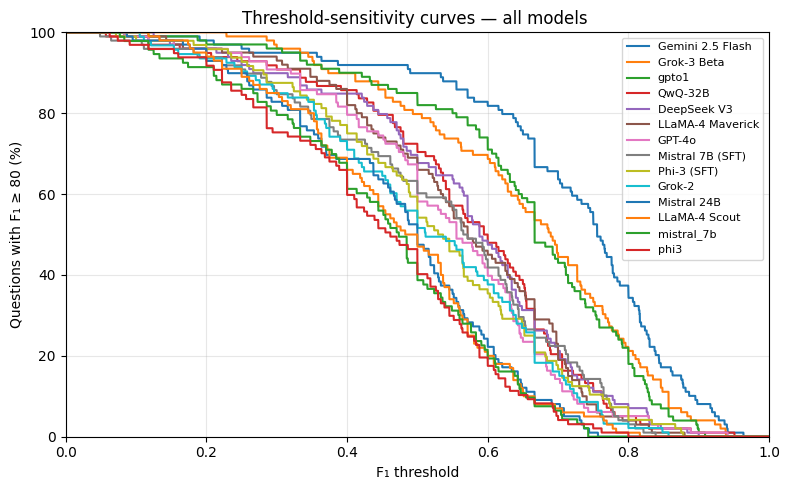

In [66]:
#!/usr/bin/env python3
"""
Plot threshold‑sensitivity (coverage) curves for every model in a judge‑results
directory, *ignoring* questions whose F1 is NaN (undefined).

NaNs arise when the judge produced no “supported/unsupported/contradictory/
missing_fact” lines for that answer.  Dropping them means curves start at 100 %
for well‑behaved models, and a partial run no longer drags the 0‑threshold
coverage below 100 %.
"""
import os, json, re
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

# ── CONFIG ───────────────────────────────────────────────────────────────
RESULT_DIR = "/work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/data/jsonl_judge_results_100_p2"
FILE_PAT   = re.compile(r"^judge_requests_(?P<model>.+)_results\.jsonl$")

# Optional: prettier legend labels
DISPLAY_NAMES = {
    "gemini2.5-flash":    "Gemini 2.5 Flash",
    "grok-3-beta":        "Grok-3 Beta",
    "gpt01":              "GPT-o1",
    "QwQ-32B":            "QwQ-32B",
    "deepseek_v3":        "DeepSeek V3",
    "llama4_maverick":    "LLaMA-4 Maverick",
    "gpt4o":              "GPT-4o",
    "mistral_7b_sft":     "Mistral 7B (SFT)",
    "phi3_sft":           "Phi-3 (SFT)",
    "grok-2":             "Grok-2",
    "mistral_24B":        "Mistral 24B",
    "llama4_scout":       "LLaMA-4 Scout",
    "mistral_7B":         "Mistral 7B",
    "phi-3-8b":           "Phi-3 ",
}

# ── helper to count confusion metrics ────────────────────────────────────
def count_confusion(content: str):
    """Return (supported, unsupported, contradictory, missing) counts."""
    sup = unsup = contrad = missing = 0
    for line in content.splitlines():
        line = line.lstrip()
        if not line.startswith("{"):
            continue
        try:
            obj = json.loads(line)
        except json.JSONDecodeError:
            continue
        if "sentence" in obj:
            lbl = obj.get("label")
            if   lbl == "supported":     sup     += 1
            elif lbl == "unsupported":   unsup   += 1
            elif lbl == "contradictory": contrad += 1
        elif "missing_fact" in obj:
            missing += 1
    return sup, unsup, contrad, missing

# ── collect per‑question F1 scores by model ─────────────────────────────
scores = defaultdict(list)   # model → list[float | nan]

for fname in os.listdir(RESULT_DIR):
    m = FILE_PAT.match(fname)
    if not m:
        continue
    model = m.group("model")

    with open(os.path.join(RESULT_DIR, fname), encoding="utf-8") as f:
        for line in f:
            if not line.strip():
                continue
            try:
                _, resp, _ = json.loads(line)               # [prompt, response, meta]
            except (ValueError, json.JSONDecodeError):
                continue                                    # malformed triple → skip
            content = resp["choices"][0]["message"]["content"]

            sup, unsup, contrad, miss = count_confusion(content)
            tp = sup
            fp = unsup + contrad
            fn = miss

            precision = tp / (tp + fp) if (tp + fp) else np.nan
            recall    = tp / (tp + fn) if (tp + fn) else np.nan
            f1 = (2 * precision * recall / (precision + recall)
                  if not (np.isnan(precision) or np.isnan(recall)) and (precision + recall)
                  else np.nan)

            scores[model].append(f1)

# ── build threshold‑coverage curves (drop NaNs) ─────────────────────────
thresholds = np.linspace(0.0, 1.0, 10001)      # 0.000‑precision grid
curves = {}                                     # model → list[% ≥ t]

for model, f1_list in scores.items():
    f1_arr = np.array(f1_list, dtype=float)
    f1_arr = f1_arr[~np.isnan(f1_arr)]          # ← ignore NaN questions entirely
    if f1_arr.size == 0:                        # skip models with no valid answers
        print(f"[warn] all NaN for model: {model}")
        continue
    coverage = (f1_arr[:, None] >= thresholds).mean(axis=0) * 100
    curves[model] = coverage

# ── plot all models on one figure ───────────────────────────────────────
plt.figure(figsize=(8, 5))

# Sort legend roughly best→worst by mean coverage
for model, cov in sorted(curves.items(),
                         key=lambda kv: kv[1].mean(),
                         reverse=True):
    label = DISPLAY_NAMES.get(model, model)
    plt.plot(thresholds, cov, label=label)

plt.xlabel("F₁ threshold")
plt.ylabel("Questions with F₁ ≥ 80 (%)")
plt.title("Threshold‑sensitivity curves — all models ")
plt.ylim(0, 100)
plt.xlim(0, 1)
plt.grid(alpha=.3)
plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "threshold_sensitivity.pdf"),
            dpi=300, bbox_inches="tight")
plt.show()


### Selecting five example for threshold selection

In [265]:
#!/usr/bin/env python3
import os
import json
import re
import csv
from collections import defaultdict

# ── CONFIG ───────────────────────────────────────────────────────────────
RESULT_DIR = "/work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/data/jsonl_judge_results_100_p2"
FILE_PAT   = re.compile(r"^judge_requests_(?P<model>.+)_results\.jsonl$")

# ── define F1 ranges ─────────────────────────────────────────────────────
f1_ranges = {
    "0.65-0.75": (0.65, 0.75),
    "0.75-0.8": (0.75, 0.8),
    "0.8-0.9": (0.8, 0.9),
    "0.9-1.0": (0.9, 1.0),
}

# ── helper to count confusion metrics ────────────────────────────────────
def count_confusion(content: str):
    sup = unsup = contrad = missing = 0
    for line in content.splitlines():
        try:
            obj = json.loads(line)
        except json.JSONDecodeError:
            continue
        lbl = obj.get("label")
        if lbl == "supported":
            sup += 1
        elif lbl == "unsupported":
            unsup += 1
        elif lbl == "contradictory":
            contrad += 1
        elif "missing_fact" in obj:
            missing += 1
    return sup, unsup, contrad, missing

# ── storage: question → ground_truth and buckets ─────────────────────────
question_data = {}  # question_text -> ground_truth_text
question_buckets = defaultdict(lambda: {label: [] for label in f1_ranges})

# ── process each model’s judge-result file ────────────────────────────────
for fname in os.listdir(RESULT_DIR):
    m = FILE_PAT.match(fname)
    if not m:
        continue
    path = os.path.join(RESULT_DIR, fname)
    with open(path, encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                parsed = json.loads(line)
            except json.JSONDecodeError:
                continue

            # detect “chat” format: first element has "messages"
            if (
                isinstance(parsed, list)
                and parsed
                and isinstance(parsed[0], dict)
                and "messages" in parsed[0]
            ):
                req_meta = parsed[0]
                comp_meta = next((p for p in parsed if isinstance(p, dict) and "choices" in p), None)
                if not comp_meta:
                    continue
                user_msgs = [m2 for m2 in req_meta["messages"] if m2.get("role") == "user"]
                raw_prompt   = user_msgs[-1]["content"] if user_msgs else ""
                judge_output = comp_meta["choices"][0]["message"]["content"]

            # detect old-style [ request_str, resp_obj, ... ]
            elif (
                isinstance(parsed, list)
                and len(parsed) >= 2
                and isinstance(parsed[1], dict)
                and "choices" in parsed[1]
            ):
                raw_prompt   = parsed[0]
                judge_output = parsed[1]["choices"][0]["message"]["content"]
            else:
                continue

            # compute F1
            sup, unsup, contrad, miss = count_confusion(judge_output)
            tp = sup
            fp = unsup + contrad
            fn = miss
            if tp + fp + fn == 0:
                continue
            precision = tp / (tp + fp) if (tp + fp) else 0.0
            recall    = tp / (tp + fn) if (tp + fn) else 0.0
            f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) else 0.0

            # extract the three blocks from the prompt
            uq_m = re.search(r"User Query:\s*(.*?)\n\nGround-Truth Answer:", raw_prompt, re.S)
            gt_m = re.search(r"Ground-Truth Answer:\s*(.*?)\n\nModel Response:", raw_prompt, re.S)
            mr_m = re.search(r"Model Response:\s*([\s\S]*)", raw_prompt, re.S)
            if not (uq_m and gt_m and mr_m):
                continue

            question     = uq_m.group(1).strip()
            ground_truth = gt_m.group(1).strip()
            answer       = mr_m.group(1).strip()

            # store ground truth once
            if question not in question_data:
                question_data[question] = ground_truth

            # bucket by F1 range (up to 5 examples per question per range)
            for label, (low, high) in f1_ranges.items():
                if low < f1 <= high and len(question_buckets[question][label]) < 5:
                    question_buckets[question][label].append({
                        "answer": answer,
                        "score":  round(f1, 4)
                    })

# ── prepare CSV rows for first 5 questions in all three ranges ────────────
rows = []
for question, buckets in question_buckets.items():
    if all(buckets[label] for label in f1_ranges):
        row = {
            "question":     question,
            "ground_truth": question_data[question],
        }
        # add one example per F1 range
        for label in f1_ranges:
            ex = buckets[label][0]
            row[f"answer_{label}"] = ex["answer"]
            row[f"score_{label}"]  = ex["score"]
        rows.append(row)
        if len(rows) >= 5:
            break

# ── write out CSV ─────────────────────────────────────────────────────────
fieldnames = ["question", "ground_truth"] + \
             [f"answer_{label}" for label in f1_ranges] + \
             [f"score_{label}"  for label in f1_ranges]

with open("/work/mech-ai-scratch/zare/Prompt_creation/llm-judge-stage1/data/selected_f1_examples.csv", "w", newline="", encoding="utf-8") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(rows)

print(f"Wrote {len(rows)} rows to selected_f1_examples.csv")


Wrote 5 rows to selected_f1_examples.csv
